# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** [Fadlan Dwi Febrio]
- **Email:** [mc189d5y1615@student.devacademy.id]
- **ID Dicoding:** [mc189d5y1615/dlann12]

## Import Semua Packages/Library yang Digunakan

In [1]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

import cv2
from google.colab import files
from PIL import Image
import skimage
from collections import defaultdict
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers import TFSMLayer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [2]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fadlandwifebrio","key":"02b7b9975d74cfa53eb11ba1247dd928"}'}

In [3]:
# Download kaggle dataset dan unzip file nya
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d piyushkumar18/animal-image-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/piyushkumar18/animal-image-classification-dataset
License(s): unknown


In [5]:
!unzip animal-image-classification-dataset.zip


Streaming output truncated to the last 5000 lines.
  inflating: Animal Image Dataset/panda/panda_00392.jpg  
  inflating: Animal Image Dataset/panda/panda_00393.jpg  
  inflating: Animal Image Dataset/panda/panda_00394.jpg  
  inflating: Animal Image Dataset/panda/panda_00395.jpg  
  inflating: Animal Image Dataset/panda/panda_00396.jpg  
  inflating: Animal Image Dataset/panda/panda_00397.jpg  
  inflating: Animal Image Dataset/panda/panda_00398.jpg  
  inflating: Animal Image Dataset/panda/panda_00399.jpg  
  inflating: Animal Image Dataset/panda/panda_00400.jpg  
  inflating: Animal Image Dataset/panda/panda_00401.jpg  
  inflating: Animal Image Dataset/panda/panda_00402.jpg  
  inflating: Animal Image Dataset/panda/panda_00403.jpg  
  inflating: Animal Image Dataset/panda/panda_00404.jpg  
  inflating: Animal Image Dataset/panda/panda_00405.jpg  
  inflating: Animal Image Dataset/panda/panda_00406.jpg  
  inflating: Animal Image Dataset/panda/panda_00407.jpg  
  inflating: Animal I

In [6]:
from collections import Counter
def count_images_per_class(dataset):
    counter = Counter()

    for root, dirs, files in os.walk(dataset):
        if root == dataset:
            continue  # Lewati direktori utama
        class_name = os.path.basename(root)
        image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]
        counter[class_name] += len(image_files)

    print("\n Jumlah gambar per kelas:")
    for cls, total in counter.items():
        print(f"{cls}: {total} gambar")

    return dict(counter)
def count_images_by_resolution(dataset):
    resolution_counts = Counter()

    for root, dirs, files in os.walk(dataset):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                image_path = os.path.join(root, file)
                try:
                    with Image.open(image_path) as img:
                        resolution = img.size  # (width, height)
                        resolution_counts[resolution] += 1
                except Exception as e:
                    print(f" Error membuka gambar: {image_path} → {e}")

    print("\n Jumlah gambar berdasarkan resolusi:")
    for res, count in resolution_counts.items():
        print(f"{res[0]}x{res[1]}: {count} gambar")

    return dict(resolution_counts)

def count_total_images(dataset):
    total = 0
    for root, dirs, files in os.walk(dataset):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                total += 1
    print(f" Total seluruh gambar hewan dalam dataset: {total} gambar")
    return total

In [7]:
dataset = "Animal Image Dataset"
count_images_per_class(dataset)
count_images_by_resolution(dataset)


 Jumlah gambar per kelas:
horse: 1452 gambar
monkey: 1451 gambar
sheep: 1452 gambar
squirrel: 1452 gambar
hen: 1452 gambar
cats: 1456 gambar
spider: 1452 gambar
elephant: 1450 gambar
dogs: 1456 gambar
butterfly: 1452 gambar
panda: 1201 gambar
cow: 1451 gambar

 Jumlah gambar berdasarkan resolusi:
300x288: 8 gambar
300x300: 443 gambar
300x200: 1562 gambar
198x300: 6 gambar
300x225: 2045 gambar
300x255: 23 gambar
300x188: 198 gambar
300x240: 182 gambar
300x204: 43 gambar
300x199: 291 gambar
300x266: 21 gambar
201x300: 58 gambar
276x300: 12 gambar
300x169: 518 gambar
300x251: 42 gambar
300x261: 20 gambar
300x212: 55 gambar
159x240: 1 gambar
300x290: 12 gambar
300x236: 23 gambar
300x229: 30 gambar
300x235: 48 gambar
300x194: 42 gambar
291x300: 13 gambar
300x216: 53 gambar
300x231: 26 gambar
300x232: 45 gambar
300x254: 25 gambar
300x211: 46 gambar
225x300: 164 gambar
300x230: 53 gambar
300x210: 53 gambar
300x238: 36 gambar
260x300: 20 gambar
300x268: 19 gambar
241x300: 26 gambar
194x300: 5

{(300, 288): 8,
 (300, 300): 443,
 (300, 200): 1562,
 (198, 300): 6,
 (300, 225): 2045,
 (300, 255): 23,
 (300, 188): 198,
 (300, 240): 182,
 (300, 204): 43,
 (300, 199): 291,
 (300, 266): 21,
 (201, 300): 58,
 (276, 300): 12,
 (300, 169): 518,
 (300, 251): 42,
 (300, 261): 20,
 (300, 212): 55,
 (159, 240): 1,
 (300, 290): 12,
 (300, 236): 23,
 (300, 229): 30,
 (300, 235): 48,
 (300, 194): 42,
 (291, 300): 13,
 (300, 216): 53,
 (300, 231): 26,
 (300, 232): 45,
 (300, 254): 25,
 (300, 211): 46,
 (225, 300): 164,
 (300, 230): 53,
 (300, 210): 53,
 (300, 238): 36,
 (260, 300): 20,
 (300, 268): 19,
 (241, 300): 26,
 (194, 300): 5,
 (300, 250): 13,
 (300, 269): 16,
 (300, 228): 50,
 (300, 206): 51,
 (200, 300): 151,
 (290, 300): 12,
 (300, 159): 12,
 (300, 195): 45,
 (196, 300): 7,
 (300, 226): 124,
 (300, 263): 30,
 (248, 300): 4,
 (300, 253): 17,
 (300, 278): 18,
 (300, 213): 64,
 (300, 273): 19,
 (300, 292): 15,
 (300, 176): 15,
 (236, 300): 6,
 (300, 184): 11,
 (300, 221): 160,
 (275, 1

In [8]:
count_total_images(dataset)

 Total seluruh gambar hewan dalam dataset: 17177 gambar


17177

In [9]:
def count_number_of_classes(dataset):
    class_folders = [d for d in os.listdir(dataset) if os.path.isdir(os.path.join(dataset, d))]
    num_classes = len(class_folders)
    print(f"📚 Jumlah kelas dalam dataset: {num_classes} kelas")
    return num_classes

count_number_of_classes(dataset)

📚 Jumlah kelas dalam dataset: 12 kelas


12

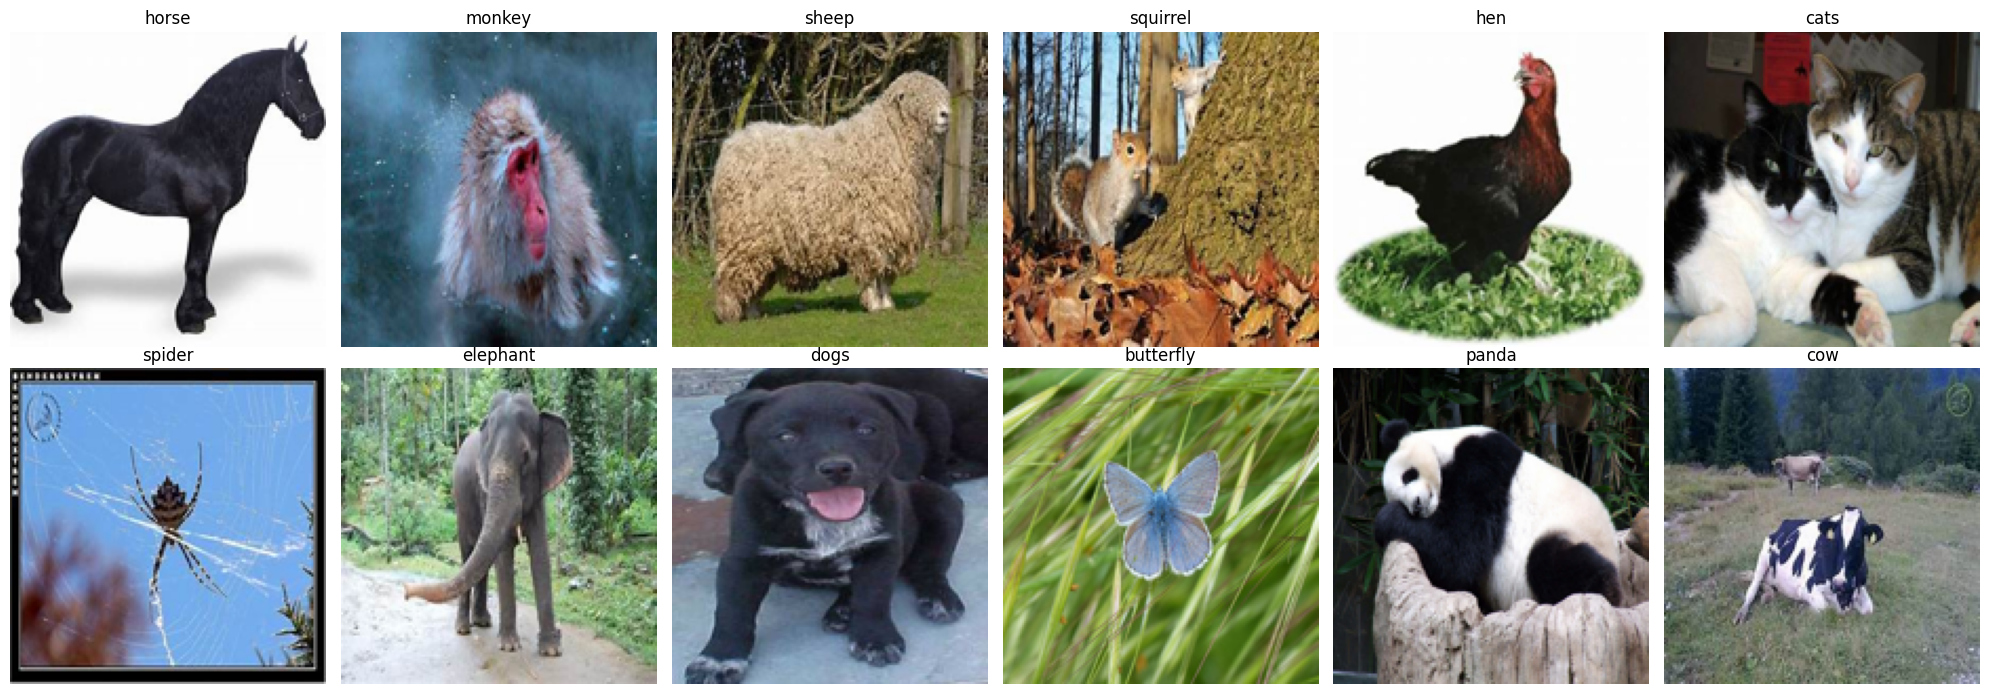

In [10]:
def show_sample_images_per_class(dataset, image_size=(150, 150)):
    class_dirs = [d for d in os.listdir(dataset) if os.path.isdir(os.path.join(dataset, d))]
    class_dirs = class_dirs[:12]  # Ambil maksimal 12 kelas

    rows = 2
    cols = 6

    plt.figure(figsize=(20, 7))

    for idx, class_name in enumerate(class_dirs):
        class_path = os.path.join(dataset, class_name)
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]

        if image_files:
            image_path = os.path.join(class_path, image_files[0])  # Ambil gambar pertama
            try:
                img = Image.open(image_path).resize(image_size)
                plt.subplot(rows, cols, idx + 1)
                plt.imshow(img)
                plt.title(f"{class_name}")
                plt.axis('off')
            except Exception as e:
                print(f" Tidak bisa membuka gambar {image_path}: {e}")
        else:
            print(f" Tidak ada gambar di folder {class_name}")

    plt.tight_layout()
    plt.show()

show_sample_images_per_class(dataset)

In [11]:
def calculate_blur_average(dataset):
    blur_scores = []

    for root, dirs, files in os.walk(dataset):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                image_path = os.path.join(root, file)
                try:
                    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        laplacian = cv2.Laplacian(img, cv2.CV_64F)
                        variance = laplacian.var()  # Variance of the Laplacian
                        blur_scores.append(variance)
                except Exception as e:
                    print(f" Gagal membuka gambar {image_path}: {e}")

    if blur_scores:
        average_blur = np.mean(blur_scores)
        print(f" Rata-rata tingkat blur (variansi Laplacian) dari gambar: {average_blur}")
    else:
        print(" Tidak ada gambar yang dapat diproses.")

calculate_blur_average(dataset)

 Rata-rata tingkat blur (variansi Laplacian) dari gambar: 2415.9525550693484


### Data Preprocessing

#### Split Dataset

In [12]:
def resize_img(dataset, min_resolution=200, max_resolution=300):
  for root, dirs, folder in os.walk(dataset):
    for file in folder:
      file_path = os.path.join(root,file)

      if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        with Image.open(file_path) as img:
          new_width = random.randint(min_resolution, max_resolution)
          new_height = random.randint(min_resolution, max_resolution)

          resized_images = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

          resized_images.save(file_path)

resize_img(dataset)

In [18]:
def split_dataset(dataset, output_base='.', train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    assert train_ratio + val_ratio + test_ratio == 1, "Total rasio harus 1"

    # Buat folder train, val, test di luar folder dataset
    train_dir = os.path.join(output_base, 'train')
    val_dir = os.path.join(output_base, 'val')
    test_dir = os.path.join(output_base, 'test')

    for directory in [train_dir, val_dir, test_dir]:
        os.makedirs(directory, exist_ok=True)

    # Loop per kelas dalam dataset asli
    for class_name in os.listdir(dataset):
        if class_name in ['train', 'val', 'test']:  # ⛔ Skip folder pembagian
            continue

        class_folder = os.path.join(dataset, class_name)
        if os.path.isdir(class_folder):
            os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
            os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
            os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

            image_files = [f for f in os.listdir(class_folder)
                           if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]
            random.shuffle(image_files)

            total_images = len(image_files)
            train_size = int(train_ratio * total_images)
            val_size = int(val_ratio * total_images)

            for i, image_file in enumerate(image_files):
                src = os.path.join(class_folder, image_file)

                if i < train_size:
                    dst = os.path.join(train_dir, class_name, image_file)
                elif i < train_size + val_size:
                    dst = os.path.join(val_dir, class_name, image_file)
                else:
                    dst = os.path.join(test_dir, class_name, image_file)

                shutil.copy(src, dst)

    print(f"✅ Train  => {train_dir}")
    print(f"✅ Val    => {val_dir}")
    print(f"✅ Test   => {test_dir}")


split_dataset(dataset)

✅ Train  => ./train
✅ Val    => ./val
✅ Test   => ./test


In [19]:
def preprocessing_dt(train_dir, val_dir, test_dir, target_size=(150,150), batch_size=32):
    # Augmentasi untuk data pelatihan
    train_data = ImageDataGenerator(
        rescale=1./255,  # Normalisasi gambar ke rentang [0, 1]
        rotation_range=20,  # Rotasi acak dalam kisaran 20 derajat
        horizontal_flip=True,  # Pembalikan horizontal gambar
        zoom_range=0.2,  # Zoom acak dalam kisaran 20%
        fill_mode='nearest'  # Cara mengisi piksel yang hilang setelah transformasi
    )

    # Rescaling untuk data validasi dan test (tanpa augmentasi)
    test_val_data = ImageDataGenerator(rescale=1./255)

    # Generator untuk training data
    train_generator = train_data.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',  # Kategori untuk multi-class classification
        shuffle=True  # Menyusun ulang data setiap epoch
    )

    # Generator untuk validation data
    val_generator = test_val_data.flow_from_directory(
        val_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',  # Kategori untuk multi-class classification
        shuffle=False  # Tidak diacak karena digunakan untuk validasi
    )

    # Generator untuk test data
    test_generator = test_val_data.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',  # Kategori untuk multi-class classification
        shuffle=False  # Tidak diacak karena digunakan untuk evaluasi akhir
    )

    return train_generator, val_generator, test_generator

# Menentukan path untuk masing-masing folder dataset
train_dir = "/content/train"
val_dir = "/content/val"
test_dir = "/content/test"

train_animal, val_animal, test_animal = preprocessing_dt(train_dir, val_dir, test_dir)

split_dataset(dataset)

Found 12018 images belonging to 12 classes.
Found 2569 images belonging to 12 classes.
Found 2590 images belonging to 12 classes.
✅ Train  => ./train
✅ Val    => ./val
✅ Test   => ./test


## Modelling

In [22]:
# Membangun model Sequential
model = Sequential()

# Memuat pretrained model MobileNetV2 dan membekukan semua lapisan
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Membekukan model MobileNetV2
base_model.trainable = False  # Membekukan seluruh model pretrained

# Menambahkan backbone pretrained model
model.add(base_model)

# Menambahkan lapisan Conv2D dan Pooling
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Menambahkan lapisan Flatten dan Dense yang dapat dilatih
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout untuk mencegah overfitting

# Output layer untuk klasifikasi
model.add(Dense(12, activation='softmax'))

# Kompilasi model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Menampilkan arsitektur model
model.summary()

<ipython-input-22-45507b362b66>:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,632,428 (10.04 MB)

 Trainable params: 374,444 (1.43 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Evaluasi dan Visualisasi

In [23]:
# ModelCheckpoint
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

# EarlyStopping
earlystop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
    mode='min'
)

# Custom callback untuk menghentikan training saat akurasi mencapai 98%
class AccuracyThresholdCallback(Callback):
    def __init__(self, threshold=0.98):
        super().__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get('accuracy')
        if acc is not None and acc >= self.threshold:
            print(f"\nAkurasi mencapai {acc:.2%}, menghentikan training.")
            self.model.stop_training = True

accuracy_threshold = AccuracyThresholdCallback(threshold=0.98)

In [24]:
history = model.fit(
    train_animal,
    validation_data=val_animal,
    epochs=20,
    callbacks=[checkpoint, earlystop, accuracy_threshold],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
376/376 ━━━━━━━━━━━━━━━━━━━━ 96s 228ms/step - accuracy: 0.2889 - loss: 2.1544 - val_accuracy: 0.8571 - val_loss: 0.4868
Epoch 2/20
376/376 ━━━━━━━━━━━━━━━━━━━━ 76s 201ms/step - accuracy: 0.7431 - loss: 0.8204 - val_accuracy: 0.8778 - val_loss: 0.3975
Epoch 3/20
376/376 ━━━━━━━━━━━━━━━━━━━━ 78s 207ms/step - accuracy: 0.8134 - loss: 0.5998 - val_accuracy: 0.8941 - val_loss: 0.3509
Epoch 4/20
376/376 ━━━━━━━━━━━━━━━━━━━━ 75s 200ms/step - accuracy: 0.8401 - loss: 0.5354 - val_accuracy: 0.8945 - val_loss: 0.3509
Epoch 5/20
376/376 ━━━━━━━━━━━━━━━━━━━━ 81s 199ms/step - accuracy: 0.8555 - loss: 0.4858 - val_accuracy: 0.8937 - val_loss: 0.3417
Epoch 6/20
376/376 ━━━━━━━━━━━━━━━━━━━━ 76s 202ms/step - accuracy: 0.8756 - loss: 0.4218 - val_accuracy: 0.8937 - val_loss: 0.3622
Epoch 7/20
376/376 ━━━━━━━━━━━━━━━━━━━━ 75s 200ms/step - accuracy: 0.8760 - loss: 0.4037 - val_accuracy: 0.8953 - val_loss: 0.3597
Epoch 8/20
376/376 ━━━━━━━━━━━━━━━━━━━━ 75s 201ms/step - accuracy: 0.8879 - loss: 0

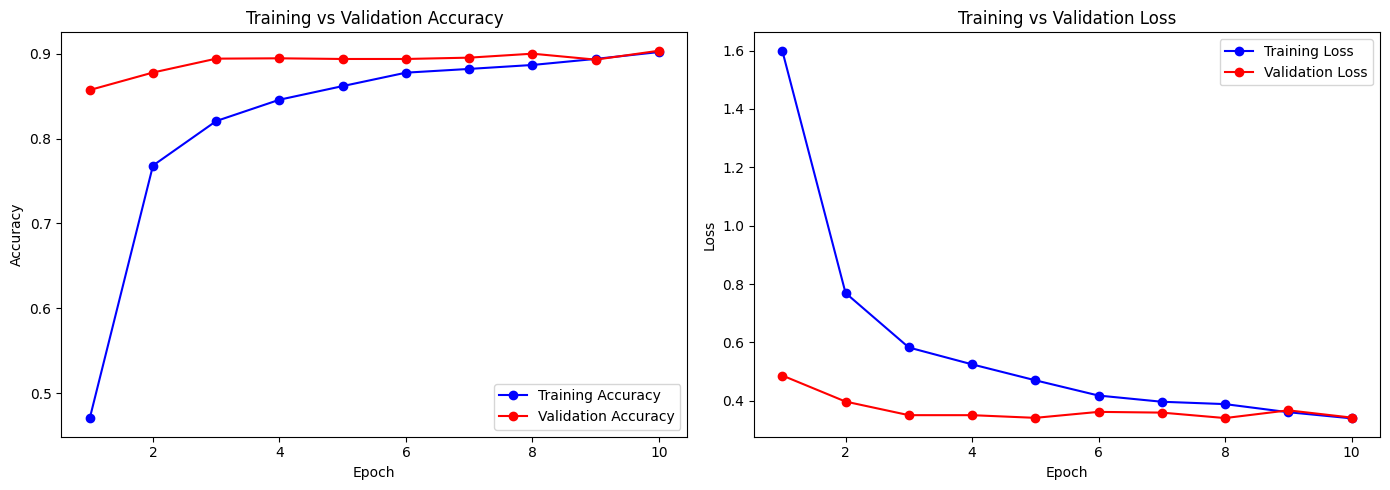

In [25]:
def plot_accuracy_and_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot Akurasi
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_accuracy_and_loss(history)

In [28]:
#  akurasi
train_accur = history.history['accuracy'][-1]
val_accur = history.history['val_accuracy'][-1]
test_loss, test_accur = model.evaluate(test_animal, verbose=1)

print(f"Training Accuracy: {train_accur:.2%}")
print(f"Validation Accuracy: {val_accur:.2%}")
print(f"Test Accuracy: {test_accur:.2%}")

81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9136 - loss: 0.2873
Training Accuracy: 90.19%
Validation Accuracy: 90.35%
Test Accuracy: 90.62%


81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step
=== Classification Report ===
              precision    recall  f1-score   support

   butterfly       0.93      0.95      0.94       219
        cats       0.96      0.93      0.94       219
         cow       0.75      0.89      0.81       219
        dogs       0.93      0.80      0.86       219
    elephant       0.90      0.95      0.93       219
         hen       0.91      0.96      0.93       219
       horse       0.91      0.82      0.86       219
      monkey       0.97      0.92      0.94       219
       panda       0.98      0.94      0.96       181
       sheep       0.85      0.89      0.87       219
      spider       0.93      0.94      0.93       219
    squirrel       0.91      0.88      0.90       219

    accuracy                           0.91      2590
   macro avg       0.91      0.91      0.91      2590
weighted avg       0.91      0.91      0.91      2590



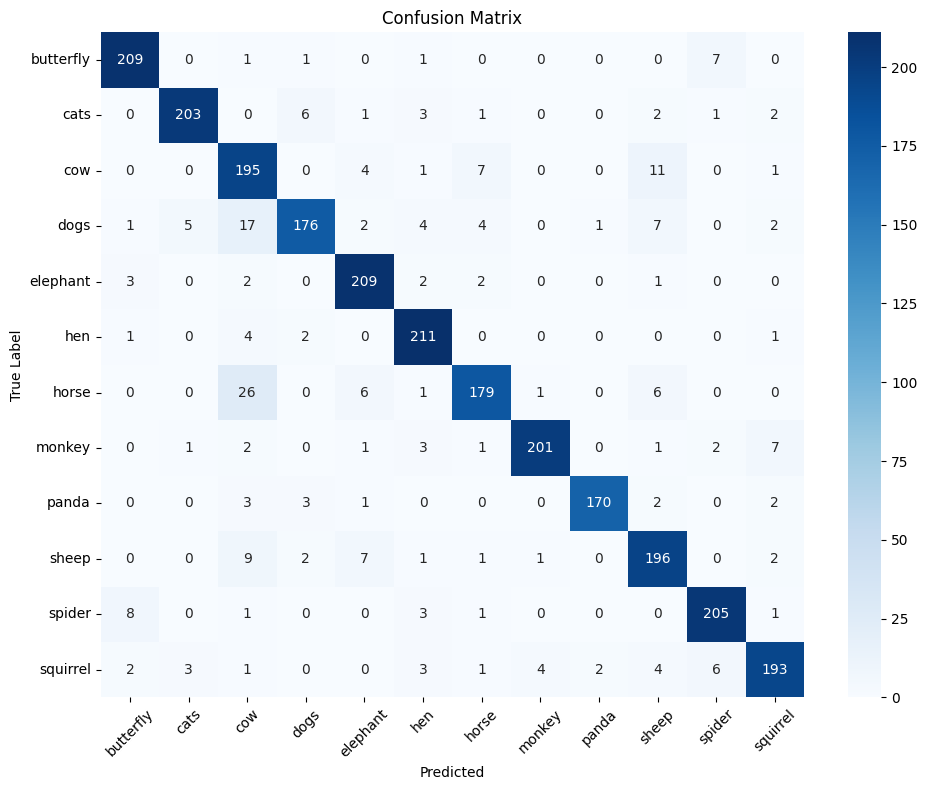

In [30]:
def evaluate_model(model, test_generator):
    test_generator.reset()
    # Predict
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    # Classification Report
    print("=== Classification Report ===")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True Label")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

evaluate_model(model, test_animal)

## Konversi Model

In [44]:
# Simpan model dalam format SavedModel
saved_model_dir = "saved_model_animal"
tf.saved_model.save(model, saved_model_dir)
print(f" Model disimpan dalam format SavedModel di: {saved_model_dir}")

# Konversi ke TensorFlow Lite (TFLite)
tflite_model_path = "animal_model.tflite"

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

# Simpan model TFLite ke file
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)
print(f"Model berhasil dikonversi ke format TFLite dan disimpan di: {tflite_model_path}")

# Konversi ke TensorFlow.js (TFJS)
!pip install tensorflowjs  # pastikan sudah terinstal

tfjs_target_dir = "tfjs_model_animal"

# Konversi SavedModel ke TFJS
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model \
  --signature_name=serving_default --saved_model_tags=serve \
  {saved_model_dir} {tfjs_target_dir}

print(f" Model berhasil dikonversi ke TensorFlow.js dan disimpan di folder: {tfjs_target_dir}")

 Model disimpan dalam format SavedModel di: saved_model_animal
Model berhasil dikonversi ke format TFLite dan disimpan di: animal_model.tflite
2025-04-22 03:52:34.238988: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745293954.258861   13382 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745293954.265024   13382 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-22 03:52:38.553315: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment varia

## Inference (Optional)

In [51]:
#Memuat model menggunakan TFSMLayer untuk SavedModel
model_layer = TFSMLayer('/content/saved_model_animal', call_endpoint='serving_default')

#Menyiapkan data input (misalnya gambar yang ingin diprediksi)
img_path = '/content/Animal Image Dataset/cats/127.jpeg'  # Ganti dengan path gambar yang ingin diprediksi

# Load gambar dan ubah ukurannya agar sesuai dengan input model
img = image.load_img(img_path, target_size=(150, 150))  # Misalnya model inputnya 150x150
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Menambah dimensi batch
img_array = img_array / 255.0  # Normalisasi (jika model dilatih dengan normalisasi)

# Lakukan inference (prediksi) menggunakan model
output = model_layer(img_array)
output_tensor = output['output_0']  # Sesuaikan dengan endpoint yang digunakan

# Menampilkan hasil
class_names = ["butterfly", "cats", "cow", "dogs", "elephant", "hen", "horse", "monkey", "panda", "sheep", "spider", "squirrel"]  # nama kelas yang sesuai
predicted_class = np.argmax(output_tensor, axis=-1)  # Menemukan kelas dengan probabilitas tertinggi
predicted_class_name = class_names[predicted_class[0]]

# Menampilkan hasil
print(f"Prediksi kelas: {predicted_class_name}")
print(f"Probabilitas untuk setiap kelas: {output_tensor.numpy()}")

# Menampilkan probabilitas dengan format yang lebih rapi
print("\nProbabilitas untuk setiap kelas:")
for i, prob in enumerate(output_tensor[0]):
    print(f"{class_names[i]:<12}: {prob.numpy():.4f}")


Prediksi kelas: cats
Probabilitas untuk setiap kelas: [[3.1203879e-08 9.9966335e-01 1.8482434e-06 2.9101115e-04 1.7983625e-08
  1.3219764e-06 4.6928331e-08 2.8538665e-07 6.4317263e-08 2.1122464e-06
  1.5481314e-06 3.8303122e-05]]

Probabilitas untuk setiap kelas:
butterfly   : 0.0000
cats        : 0.9997
cow         : 0.0000
dogs        : 0.0003
elephant    : 0.0000
hen         : 0.0000
horse       : 0.0000
monkey      : 0.0000
panda       : 0.0000
sheep       : 0.0000
spider      : 0.0000
squirrel    : 0.0000
